# Imports

In [353]:
import sys
import numpy as np
import datetime, calendar
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer  
from sklearn import preprocessing
np.set_printoptions(threshold=sys.maxsize)

# Data loading

In [369]:
X_train = pd.read_csv("train.csv", sep=";")    
X_test = pd.read_csv("test.csv", sep=";") 

# Data preprocessing

### Remove ID and TIMESTAMP

In [370]:
X_train.drop('ID',  axis='columns', inplace=True)
X_train.drop('TIMESTAMP',  axis='columns', inplace=True)
X_test.drop('TIMESTAMP',  axis='columns', inplace=True)

### Remove rows with empty fields

In [371]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

### Transform dates

In [372]:
month_names = {month.lower(): index for index, month in enumerate(calendar.month_name) if month}
def replaceMonthName(date):
    index = date.find("/")
    month_name = f"{date[index+1:]}".lower()
    return date[:index] + f"{month_names[month_name]}".zfill(2)

def processDates(data):
    data['DEPARTURE'] = data['DEPARTURE'].str.replace("-","/")
    data['ARRIVAL'] = data['ARRIVAL'].str.replace("-","/")
    data['DEPARTURE'] = data['DEPARTURE'].apply(lambda x: f"{replaceMonthName(x)}")
    data['ARRIVAL'] = data['ARRIVAL'].apply(lambda x: f"{replaceMonthName(x)}")
    
processDates(X_train)
processDates(X_test)

### Convert distance to float

In [373]:
X_train['DISTANCE'] = X_train['DISTANCE'].str.strip()
X_train['DISTANCE'] = X_train['DISTANCE'].apply(lambda x: x.replace(',','.'))
X_test['DISTANCE'] = X_test['DISTANCE'].apply(lambda x: x.replace(',','.'))
X_train['DISTANCE'] = pd.to_numeric(X_train['DISTANCE'], errors='coerce')

### Encode categorical columns

In [374]:
def hot_encode_categorical_inputs(X_train, X_test, columns):
    oe_style = OneHotEncoder(handle_unknown = 'ignore')   
    
    for col in columns:        
        X_train_enc = oe_style.fit_transform(X_train[[col]])
        X_train = X_train.join(pd.DataFrame(X_train_enc.toarray(), columns=oe_style.categories_))
        X_test_enc = oe_style.transform(X_test[[col]])   
        X_test = X_test.join(pd.DataFrame(X_test_enc.toarray(), columns=oe_style.categories_))
        X_train = X_train.drop([col], axis=1)
        X_test = X_test.drop([col], axis=1)   
    
    return X_train, X_test

def binary_encode_categorical_inputs(X_train, X_test, columns):
    
    for col in columns:   
        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)
        
    return X_train, X_test

hot_encode_cols = ['WEBSITE','DEVICE','HAUL_TYPE','TRIP_TYPE', 'PRODUCT']
label_encode_cols = ['TRAIN', 'SMS']

[X_train, X_test] = hot_encode_categorical_inputs(X_train, X_test, hot_encode_cols)
[X_train, X_test] = binary_encode_categorical_inputs(X_train, X_test, label_encode_cols)

In [360]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

### Normalize data

In [375]:
def normalize(X_train, X_test, columns):
    # copy the data
    train = X_train.copy()
    test = X_test.copy()
    normalizer = preprocessing.MinMaxScaler()
    for column in columns:
        train[column] = normalizer.fit_transform(np.array(train[column]).reshape(-1,1))
        test[column] = normalizer.transform(np.array(test[column]).reshape(-1,1))
    return train, test
    
[X_train, X_test] = normalize(X_train, X_test, ['DISTANCE', 'DEPARTURE', 'ARRIVAL'])

### Prepare targets

In [376]:
def prepare_targets(y_train):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)    
    y_train_enc = pd.DataFrame(y_train_enc)
    return y_train_enc

Y_train = X_train['EXTRA_BAGGAGE']
X_train = X_train.drop('EXTRA_BAGGAGE',  axis='columns')

Y_train = prepare_targets(Y_train)
Y_train.isin([1]).sum()

0    9799
dtype: int64

In [363]:
saveData("IDs.pickle", X_test["ID"].values)
X_test = X_test.drop('ID',  axis='columns')

# Feature extraction. PCA

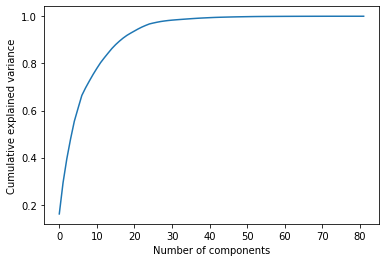

In [364]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=82)
pca.fit(X_train)
fig = plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
fig.savefig('Cumulative explained variance.png', dpi=fig.dpi)

In [365]:
pca = PCA(n_components=30)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
pca_std = np.std(X_train)

### Save data

In [366]:
def saveData(filename, data):
    pickle_out = open(filename, "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close() 


saveData("X_train.pickle", X_train)
saveData("Y_train.pickle", Y_train.values)
saveData("X_test.pickle", X_test)



## Neural network training

In [367]:
#Dependencies
import time
import tensorflow as tf
import pickle
import numpy as np
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping


pickle_in = open("X_train.pickle", "rb")
X_train = pickle.load(pickle_in)

pickle_in = open("Y_train.pickle", "rb")
Y_train = pickle.load(pickle_in)
#nonzeroind = np.nonzero(Y_train)[0]
early_stop = EarlyStopping(monitor='val_accuracy', mode='min', patience=50)
NAME = "NN-{}".format(int(time.time()))
tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

model = Sequential()
model.add(Dense(100, input_dim=30, activation='relu')) 
model.add(Dense(50, activation='relu')) 
model.add(Dense(20, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=2500, epochs=200,validation_split=0.1, callbacks=[tensorBoard,early_stop], verbose=1,shuffle=True)
model.save('model')


Epoch 1/200
18/18 [==============================] - 2s 73ms/step - loss: 0.5522 - accuracy: 0.8050 - val_loss: 0.4940 - val_accuracy: 0.7979
Epoch 2/200
18/18 [==============================] - 0s 9ms/step - loss: 0.4829 - accuracy: 0.8040 - val_loss: 0.4728 - val_accuracy: 0.7979
Epoch 3/200
18/18 [==============================] - 0s 10ms/step - loss: 0.4712 - accuracy: 0.8033 - val_loss: 0.4701 - val_accuracy: 0.7979
Epoch 4/200
18/18 [==============================] - 0s 13ms/step - loss: 0.4650 - accuracy: 0.8053 - val_loss: 0.4687 - val_accuracy: 0.7979
Epoch 5/200
18/18 [==============================] - 0s 11ms/step - loss: 0.4636 - accuracy: 0.8049 - val_loss: 0.4677 - val_accuracy: 0.7979
Epoch 6/200
18/18 [==============================] - 0s 10ms/step - loss: 0.4665 - accuracy: 0.8027 - val_loss: 0.4668 - val_accuracy: 0.7979
Epoch 7/200
18/18 [==============================] - 0s 11ms/step - loss: 0.4626 - accuracy: 0.8037 - val_loss: 0.4656 - val_accuracy: 0.7979
Epoch 8

18/18 [==============================] - 0s 9ms/step - loss: 0.4215 - accuracy: 0.8121 - val_loss: 0.4827 - val_accuracy: 0.7895
Epoch 59/200
18/18 [==============================] - 0s 11ms/step - loss: 0.4232 - accuracy: 0.8127 - val_loss: 0.4837 - val_accuracy: 0.7919
Epoch 60/200
18/18 [==============================] - 0s 9ms/step - loss: 0.4187 - accuracy: 0.8129 - val_loss: 0.4848 - val_accuracy: 0.7903
Epoch 61/200
18/18 [==============================] - 0s 9ms/step - loss: 0.4212 - accuracy: 0.8123 - val_loss: 0.4855 - val_accuracy: 0.7911
Epoch 62/200
18/18 [==============================] - 0s 10ms/step - loss: 0.4196 - accuracy: 0.8116 - val_loss: 0.4877 - val_accuracy: 0.7911
Epoch 63/200
18/18 [==============================] - 0s 10ms/step - loss: 0.4174 - accuracy: 0.8135 - val_loss: 0.4903 - val_accuracy: 0.7911
Epoch 64/200
18/18 [==============================] - 0s 8ms/step - loss: 0.4186 - accuracy: 0.8116 - val_loss: 0.4890 - val_accuracy: 0.7905
Epoch 65/200
18/

18/18 [==============================] - 0s 8ms/step - loss: 0.3915 - accuracy: 0.8247 - val_loss: 0.5232 - val_accuracy: 0.7726
Epoch 116/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3918 - accuracy: 0.8250 - val_loss: 0.5238 - val_accuracy: 0.7746
Epoch 117/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3889 - accuracy: 0.8267 - val_loss: 0.5237 - val_accuracy: 0.7654
Epoch 118/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3882 - accuracy: 0.8292 - val_loss: 0.5223 - val_accuracy: 0.7770
Epoch 119/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3872 - accuracy: 0.8265 - val_loss: 0.5223 - val_accuracy: 0.7736
Epoch 120/200
18/18 [==============================] - 0s 9ms/step - loss: 0.3851 - accuracy: 0.8285 - val_loss: 0.5233 - val_accuracy: 0.7744
Epoch 121/200
18/18 [==============================] - 0s 7ms/step - loss: 0.3849 - accuracy: 0.8292 - val_loss: 0.5278 - val_accuracy: 0.7700
Epoch 122/200

18/18 [==============================] - 0s 9ms/step - loss: 0.3685 - accuracy: 0.8366 - val_loss: 0.5593 - val_accuracy: 0.7654
Epoch 173/200
18/18 [==============================] - 0s 9ms/step - loss: 0.3667 - accuracy: 0.8378 - val_loss: 0.5594 - val_accuracy: 0.7710
Epoch 174/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3599 - accuracy: 0.8405 - val_loss: 0.5568 - val_accuracy: 0.7628
Epoch 175/200
18/18 [==============================] - 0s 9ms/step - loss: 0.3646 - accuracy: 0.8385 - val_loss: 0.5600 - val_accuracy: 0.7537
Epoch 176/200
18/18 [==============================] - 0s 9ms/step - loss: 0.3692 - accuracy: 0.8378 - val_loss: 0.5581 - val_accuracy: 0.7660
Epoch 177/200
18/18 [==============================] - 0s 10ms/step - loss: 0.3659 - accuracy: 0.8374 - val_loss: 0.5563 - val_accuracy: 0.7620
Epoch 178/200
18/18 [==============================] - 0s 8ms/step - loss: 0.3647 - accuracy: 0.8394 - val_loss: 0.5566 - val_accuracy: 0.7646
Epoch 179/20

# Model prediction

In [368]:
from keras.models import load_model
pickle_in = open("X_test.pickle", "rb")
X_test = pickle.load(pickle_in)

pickle_in = open("IDs.pickle", "rb")
IDs = pickle.load(pickle_in)

p = model.predict(X_test)
p = np.array(p).reshape(-1)
IDs = np.array(IDs).reshape(-1)

result = pd.DataFrame({'ID': IDs, 'PREDICTION': p})
result.to_csv('result.csv', index=False)
print(result.head())
print(p[p>0.5].size)

   ID  PREDICTION
0   0    0.008455
1   1    0.106292
2   2    0.001918
3   3    0.146255
4   4    0.028830
3162
